# 1.Imports

In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, Dropout
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from tensorflow.python.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from keras_tuner import HyperParameters
from keras_tuner import RandomSearch
from keras.utils import  to_categorical
import zipfile
from PIL import Image
import os
import random
import nbconvert

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Read the input files
train_df = pd.read_csv('train.csv.zip')
test_df = pd.read_csv('test.csv.zip')


In [3]:
# read the images file
file_name = "images.zip"

# opening the zip file in READ mode
with zipfile.ZipFile(file_name, 'r') as zip:
    # get a list of all archived file names from the zip
    image_names= zip.namelist()
    # use a list comprehension to get a list of image filenames (with .jpg extensions)
    list_of_image_filenames = [filename for filename in image_names if filename.endswith(('.jpg'))]

    print(f'The number of images in the zip file is: {len(list_of_image_filenames)}')

The number of images in the zip file is: 1584


# 2. Data Exploration

In [4]:
train_df.shape

(990, 194)

In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 990 entries, 0 to 989
Columns: 194 entries, id to texture64
dtypes: float64(192), int64(1), object(1)
memory usage: 1.5+ MB


In [6]:
# Checking for missing values
train_df.isna().sum().max()

0

In [7]:
# Checking for duplicates()
train_df.duplicated().sum()

0

In [8]:
train_df.dtypes

id             int64
species       object
margin1      float64
margin2      float64
margin3      float64
              ...   
texture60    float64
texture61    float64
texture62    float64
texture63    float64
texture64    float64
Length: 194, dtype: object

In [9]:
train_df.describe()

,id,margin1,margin2,margin3,margin4,margin5,margin6,margin7,margin8,margin9,...,texture55,texture56,texture57,texture58,texture59,texture60,texture61,texture62,texture63,texture64
count,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,...,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000
mean,799.595960,0.017412,0.028539,0.031988,0.023280,0.014264,0.038579,0.019202,0.001083,0.007167,...,0.036501,0.005024,0.015944,0.011586,0.016108,0.014017,0.002688,0.020291,0.008989,0.019420
std,452.477568,0.019739,0.038855,0.025847,0.028411,0.018390,0.052030,0.017511,0.002743,0.008933,...,0.063403,0.019321,0.023214,0.025040,0.015335,0.060151,0.011415,0.039040,0.013791,0.022768
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,415.250000,0.001953,0.001953,0.013672,0.005859,0.001953,0.000000,0.005859,0.000000,0.001953,...,0.000000,0.000000,0.000977,0.000000,0.004883,0.000000,0.000000,0.000000,0.000000,0.000977
50%,802.500000,0.009766,0.011719,0.025391,0.013672,0.007812,0.015625,0.015625,0.000000,0.005859,...,0.004883,0.000000,0.005859,0.000977,0.012695,0.000000,0.000000,0.003906,0.002930,0.011719
75%,1195.500000,0.025391,0.041016,0.044922,0.029297,0.017578,0.056153,0.029297,0.000000,0.007812,...,0.043701,0.000000,0.022217,0.009766,0.021484,0.000000,0.000000,0.023438,0.012695,0.029297
max,1584.000000,0.087891,0.205080,0.156250,0.169920,0.111330,0.310550,0.091797,0.031250,0.076172,...,0.429690,0.202150,0.172850,0.200200,0.106450,0.578130,0.151370,0.375980,0.086914,0.141600


In [10]:
train_df.head()

,id,species,margin1,margin2,margin3,margin4,margin5,margin6,margin7,margin8,...,texture55,texture56,texture57,texture58,texture59,texture60,texture61,texture62,texture63,texture64
0,1,Acer_Opalus,0.007812,0.023438,0.023438,0.003906,0.011719,0.009766,0.027344,0.0,...,0.007812,0.000000,0.002930,0.002930,0.035156,0.0,0.0,0.004883,0.000000,0.025391
1,2,Pterocarya_Stenoptera,0.005859,0.000000,0.031250,0.015625,0.025391,0.001953,0.019531,0.0,...,0.000977,0.000000,0.000000,0.000977,0.023438,0.0,0.0,0.000977,0.039062,0.022461
2,3,Quercus_Hartwissiana,0.005859,0.009766,0.019531,0.007812,0.003906,0.005859,0.068359,0.0,...,0.154300,0.000000,0.005859,0.000977,0.007812,0.0,0.0,0.000000,0.020508,0.002930
3,5,Tilia_Tomentosa,0.000000,0.003906,0.023438,0.005859,0.021484,0.019531,0.023438,0.0,...,0.000000,0.000977,0.000000,0.000000,0.020508,0.0,0.0,0.017578,0.000000,0.047852
4,6,Quercus_Variabilis,0.005859,0.003906,0.048828,0.009766,0.013672,0.015625,0.005859,0.0,...,0.096680,0.000000,0.021484,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.031250


In [11]:
# Identifying the column names
margin_cols = train_df.columns[train_df.columns.str.contains('margin')].size
shape_cols = train_df.columns[train_df.columns.str.contains('shape')].size
texture_cols = train_df.columns[train_df.columns.str.contains('texture')].size

print('Number of columns with "margin" in their names: ', margin_cols)
print('Number of columns with "shape" in their names: ', shape_cols)
print('Number of columns with "texture" in their names: ', texture_cols)

Number of columns with "margin" in their names:  64
Number of columns with "shape" in their names:  64
Number of columns with "texture" in their names:  64


In [12]:
# Count the number of species
num_classes = train_df['species'].unique().shape[0]
num_classes

99

In [13]:
classes = train_df['species'].unique().tolist()
classes

['Acer_Opalus',
 'Pterocarya_Stenoptera',
 'Quercus_Hartwissiana',
 'Tilia_Tomentosa',
 'Quercus_Variabilis',
 'Magnolia_Salicifolia',
 'Quercus_Canariensis',
 'Quercus_Rubra',
 'Quercus_Brantii',
 'Salix_Fragilis',
 'Zelkova_Serrata',
 'Betula_Austrosinensis',
 'Quercus_Pontica',
 'Quercus_Afares',
 'Quercus_Coccifera',
 'Fagus_Sylvatica',
 'Phildelphus',
 'Acer_Palmatum',
 'Quercus_Pubescens',
 'Populus_Adenopoda',
 'Quercus_Trojana',
 'Alnus_Sieboldiana',
 'Quercus_Ilex',
 'Arundinaria_Simonii',
 'Acer_Platanoids',
 'Quercus_Phillyraeoides',
 'Cornus_Chinensis',
 'Liriodendron_Tulipifera',
 'Cytisus_Battandieri',
 'Rhododendron_x_Russellianum',
 'Alnus_Rubra',
 'Eucalyptus_Glaucescens',
 'Cercis_Siliquastrum',
 'Cotinus_Coggygria',
 'Celtis_Koraiensis',
 'Quercus_Crassifolia',
 'Quercus_Kewensis',
 'Cornus_Controversa',
 'Quercus_Pyrenaica',
 'Callicarpa_Bodinieri',
 'Quercus_Alnifolia',
 'Acer_Saccharinum',
 'Prunus_X_Shmittii',
 'Prunus_Avium',
 'Quercus_Greggii',
 'Quercus_Suber'

In [14]:
# Count the number of datapoints for every species
train_df['species'].value_counts()

species
Acer_Opalus                    10
Crataegus_Monogyna             10
Acer_Mono                      10
Magnolia_Heptapeta             10
Acer_Capillipes                10
                               ..
Alnus_Rubra                    10
Rhododendron_x_Russellianum    10
Cytisus_Battandieri            10
Liriodendron_Tulipifera        10
Sorbus_Aria                    10
Name: count, Length: 99, dtype: int64

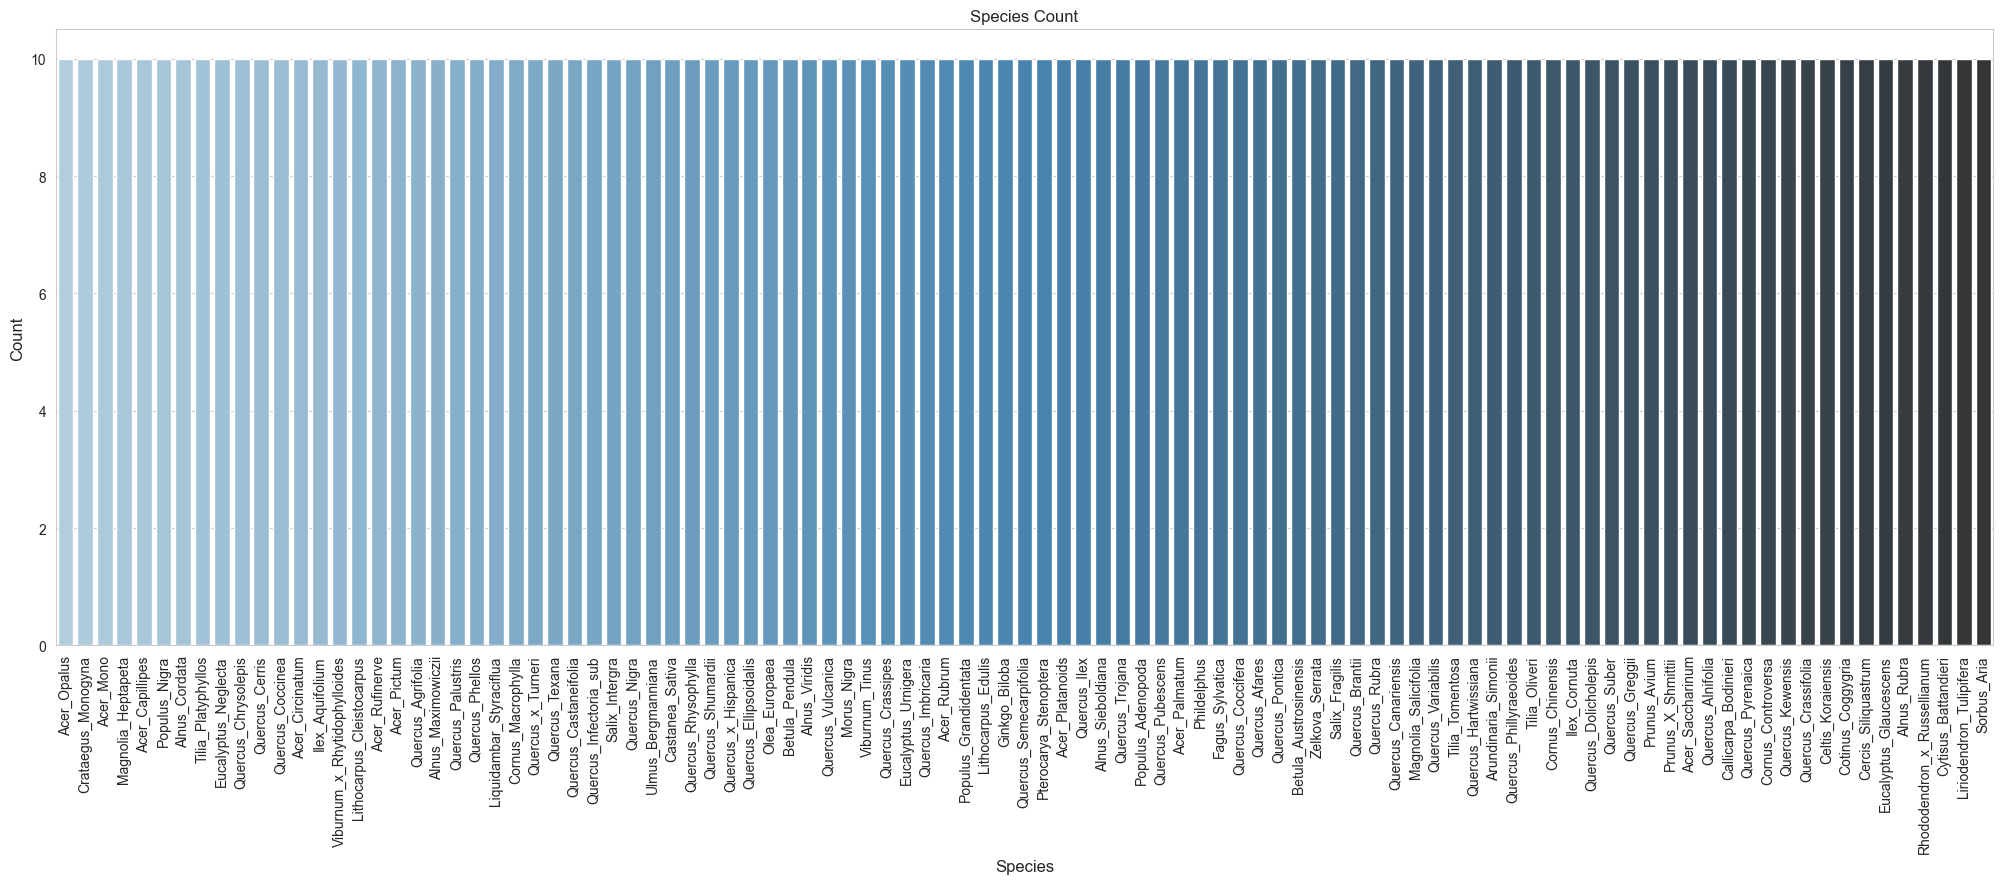

In [15]:
# Count the number of datapoints for every species
species_count = train_df['species'].value_counts()

# Plot the count for every species
plt.figure(figsize=(25,8))
sns.barplot(x = species_count.index, y = species_count.values, palette="Blues_d")
plt.title('Species Count')
plt.xticks(rotation='vertical')
plt.ylabel('Count', fontsize=12)
plt.xlabel('Species', fontsize=12)
plt.show()

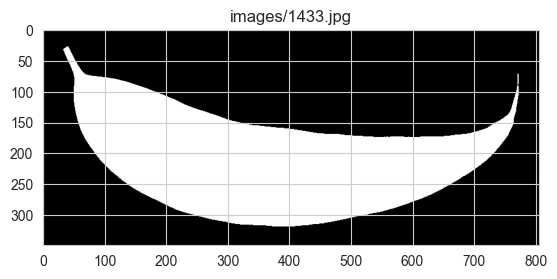

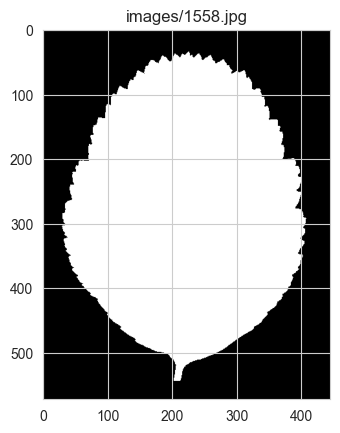

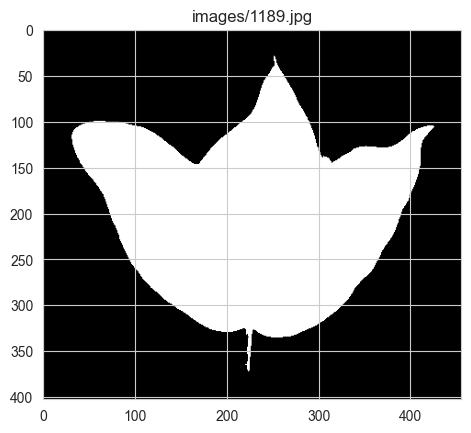

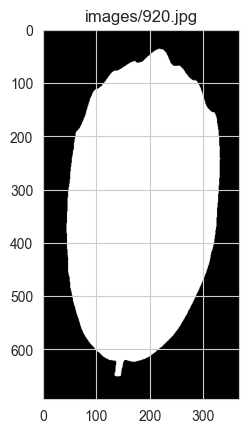

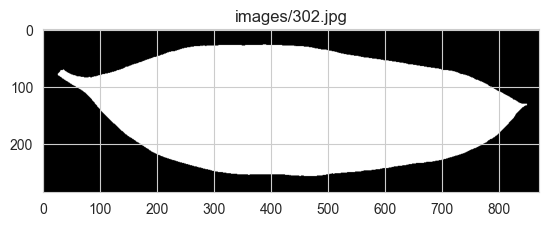

In [16]:
# Match the image filenames in the zip file with the ids in the train_df DataFrame
matched_images = [img for img in image_names if any(str(id) in img for id in train_df['id'])]

# Randomly pick 5 images
random.seed(4)
five_images = random.sample(matched_images, 5)

# Display the images
for img_name in five_images:
    with zipfile.ZipFile('images.zip', 'r') as myzip:
        with myzip.open(img_name) as myfile:
            img = Image.open(myfile)
            plt.imshow(img, cmap='gray')
            plt.title(img_name)
            plt.show()

# 3. Pre-modelling

In [17]:
# Preprocessing
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split

# Copy the original DataFrame
processed_df = train_df.copy()

# Initialize the encoder
le = LabelEncoder()

# Encode the 'species' column
processed_df['species'] = le.fit_transform(processed_df['species'])

# Initialize the scaler
scaler = MinMaxScaler()

# Scale numeric columns. Exclude 'id' and 'species' from being scaled
numeric_cols = processed_df.columns.drop(['id', 'species'])
processed_df[numeric_cols] = scaler.fit_transform(processed_df[numeric_cols])

# Split the DataFrame into features and target
X = processed_df.drop(columns=['id', 'species'])
y = processed_df['species']

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [18]:
# Print the first 5 rows of the processed DataFrame
processed_df.head()

,id,species,margin1,margin2,margin3,margin4,margin5,margin6,margin7,margin8,...,texture55,texture56,texture57,texture58,texture59,texture60,texture61,texture62,texture63,texture64
0,1,3,0.088883,0.114287,0.150003,0.022987,0.105264,0.031447,0.297875,0.0,...,0.018181,0.000000,0.016951,0.014635,0.330258,0.0,0.0,0.012987,0.000000,0.179315
1,2,49,0.066662,0.000000,0.200000,0.091955,0.228070,0.006289,0.212763,0.0,...,0.002274,0.000000,0.000000,0.004880,0.220178,0.0,0.0,0.002599,0.449433,0.158623
2,3,65,0.066662,0.047620,0.124998,0.045975,0.035085,0.018867,0.744676,0.0,...,0.359096,0.000000,0.033896,0.004880,0.073387,0.0,0.0,0.000000,0.235957,0.020692
3,5,94,0.000000,0.019046,0.150003,0.034481,0.192976,0.062892,0.255324,0.0,...,0.000000,0.004833,0.000000,0.000000,0.192654,0.0,0.0,0.046752,0.000000,0.337938
4,6,84,0.066662,0.019046,0.312499,0.057474,0.122806,0.050314,0.063826,0.0,...,0.224999,0.000000,0.124293,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.220692


In [19]:
# Reshape the data
def reshape_for_cnn(X, n_channels):
    dim = int(np.sqrt(X.shape[1] // n_channels))
    return X.values.reshape(-1, dim, dim, n_channels)

# Define number of channels
n_channels = 3  # margin, shape, texture

# Reshape training, validation data
X_train_reshaped = reshape_for_cnn(X_train, n_channels)
X_val_reshaped = reshape_for_cnn(X_val, n_channels)

In [20]:
# To ensure reproducibility in the experiments, we fix the random seed for all components in the code
seed_value=1

# 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set Python built-in pseudorandom generator at a fixed value
random.seed(seed_value)

# 3. Set NumPy pseudorandom generator at a fixed value
np.random.seed(seed_value)

# 4. Set TensorFlow pseudorandom generator at a fixed value
tf.random.set_seed(seed_value)

# 4. Modelling

Create a convolutional neural network (CNN) model for image classification. The class constructor accepts the input shape of images and the number of class to predict.
In its `build` method, the model dynamically configures its layers, including convolutional and pooling layers, followed by dense layers with dropout for regularization. Hyperparameters such as filter size, kernel size, and learning rate are optimized to improve performance on specific datasets.

In [21]:
class CNNHyperModel:
    def __init__(self, num_class):
        self.num_class = num_class

    def build(self, hp: HyperParameters):
        model = Sequential()
        model.add(Conv2D(256, (3, 3), padding='same', activation='relu', input_shape=(8, 8, 3)))
        model.add(Flatten())
        model.add(Dropout(0.5))
        model.add(Dense(hp.Choice('dense_layer_1_units', values=[384, 512]), activation='relu', kernel_regularizer=l2(0.001)))
        model.add(Dropout(0.5))
        model.add(Dense(hp.Choice('dense_layer_2_units', values=[384, 512]), activation='relu', kernel_regularizer=l2(0.001)))
        model.add(Dense(self.num_class, activation='softmax'))

        model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

        return model

hypermodel = CNNHyperModel(num_class=num_classes)

Utilizing a RandomSearch tuner to identify the optimal hyperparameters for a model, as opposed to manually selecting hyperparameters for testing a few models, presents a more efficient and effective method. This approach systematically explores a wide range of hyperparameter combinations across 20 trials, each with 5 executions to ensure reliability in finding the best set. By automating the search, it significantly increases the likelihood of discovering an optimal configuration that might not be evident through manual selection. This method leverages computational power to evaluate numerous possibilities in a structured manner, thereby reducing human bias and oversight. It leads to potentially higher model accuracy and performance by rigorously testing a broad spectrum of configurations, ensuring that the final model, trained with the best hyperparameters, is highly tuned to the specific characteristics of the dataset.

In [22]:
# Searching for the best hyperparameters
tuner = RandomSearch(
    hypermodel.build,
    objective='val_accuracy',
    max_trials=20,
    executions_per_trial=5,
    directory='random_search',
    project_name='leaf_classification'
)
tuner.search(
    x=X_train_reshaped,
    y=to_categorical(y_train, num_classes=num_classes),
    epochs=10,
    validation_split=0.2
)

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Build the model with the optimal hyperparameters
best_model = tuner.hypermodel.build(best_hps)

# Train the best model
history = best_model.fit(
    X_train_reshaped,
    to_categorical(y_train, num_classes=num_classes),
    epochs=10,
    validation_data=(X_val_reshaped, to_categorical(y_val, num_classes=num_classes))
)

Reloading Tuner from random_search\leaf_classification\tuner0.json
Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 143ms/step - accuracy: 0.0172 - loss: 5.4977 - val_accuracy: 0.1212 - val_loss: 5.0313
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 139ms/step - accuracy: 0.0927 - loss: 4.7709 - val_accuracy: 0.1313 - val_loss: 4.1778
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step - accuracy: 0.1888 - loss: 3.8135 - val_accuracy: 0.4848 - val_loss: 2.7416
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.4002 - loss: 2.7842 - val_accuracy: 0.6465 - val_loss: 1.8809
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 0.5545 - loss: 2.1756 - val_accuracy: 0.8030 - val_loss: 1.5403
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 0.6782 - loss: 1.8085 - val_accuracy: 0.8232 - val_loss: 1.4087
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 0.7690 - loss: 1.5593 - val_accuracy: 0.8788 - val_loss: 1.2063
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━

In [23]:
test_loss, test_acc = best_model.evaluate(X_val_reshaped, to_categorical(y_val, num_classes=num_classes))
print(f"Validation accuracy: {test_acc*100:.2f}%")
print(f"Validation loss: {test_loss:.4f}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9387 - loss: 0.9748
Validation accuracy: 92.93%
Validation loss: 0.9852


The model achieved the final training accuracy of 93.87% and the validation accuracy of 92.93%, is largely due to precise hyperparameter tuning. 

In [24]:
model_config = best_model.get_config()

model_layers = model_config['layers']

# Convolutional layer
conv_layer_config = next(layer for layer in model_layers if layer['class_name'] == 'Conv2D')
conv_filters = conv_layer_config['config'].get('filters')

# Dense layers
dense_layers_config = [layer for layer in model_layers if layer['class_name'] == 'Dense']
dense_units = [config['config'].get('units') for config in dense_layers_config]

# Dropout layer
dropout_layer_config = next(layer for layer in model_layers if layer['class_name'] == 'Dropout')
dropout_rate = dropout_layer_config['config'].get('rate')

# L2 Regularization
l2_reg_config = next(config['config'].get('kernel_regularizer', {}) for config in dense_layers_config if config['config'].get('kernel_regularizer'))
l2_regularization = l2_reg_config.get('l2') if l2_reg_config else None

# These are some of the most important hyperparameters in this model.
print(f"Conv2D filters: {conv_filters}")
print(f"Dense units: {dense_units}")
print(f"Dropout rate: {dropout_rate}")
print(f"L2 regularization: {l2_regularization}")

Conv2D filters: 256
Dense units: [384, 384, 99]
Dropout rate: 0.5
L2 regularization: None


In [25]:
# Assuming `best_model` is your best model obtained from the tuner
optimizer_config = best_model.optimizer.get_config()
learning_rate = optimizer_config.get('learning_rate')

print("The learning rate for the best model is:", learning_rate)

The learning rate for the best model is: 0.0010000000474974513


The best model, determined through hyperparameter tuning, features a configuration optimized for performance. It includes a convolutional layer (Conv2D) with 256 filters to capture spatial hierarchies of the input data efficiently. The architecture comprises three dense layers with 384 units each for the first two layers and 99 units for the final layer, likely tailored for class prediction. A dropout rate of 0.5 is applied to mitigate overfitting by randomly ignoring half of the neurons' outputs during training. L2 regularization is not employed, indicating no additional penalty on the weights' magnitude. The optimal learning rate (.001) identified for this model is retrieved from the tuner's best hyperparameters, enhancing the model's training efficiency and effectiveness in achieving high accuracy.

In [26]:
#  Goodness of fit metrics

from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score
import numpy as np

# Assuming your model is named 'best_model' and it has been trained as per the provided code snippet.

# Predictions on the validation set
y_pred = best_model.predict(X_val_reshaped)
y_pred_classes = np.argmax(y_pred, axis=1)

# Convert validation labels from categorical to class integers
y_val_classes = np.argmax(to_categorical(y_val, num_classes=num_classes), axis=1)

# Calculate Accuracy
accuracy = accuracy_score(y_val_classes, y_pred_classes)

# Calculate Precision, Recall, and F1 Score
precision, recall, f1, _ = precision_recall_fscore_support(y_val_classes, y_pred_classes, average='weighted')


# Print the metrics
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")



7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Accuracy: 0.9292929292929293
Precision: 0.9416666666666667
Recall: 0.9292929292929293
F1 Score: 0.9226952060285394


The model demonstrates strong performance across all reported metrics, indicating effective learning and generalization capabilities. An accuracy of 92.93% signifies that a high proportion of the predictions made by the model are correct. The precision of 94.17% suggests that when the model predicts a class, it is correct about 94% of the time, highlighting its reliability in making positive predictions. The recall, also at 92.93%, indicates that the model is capable of identifying nearly 93% of all actual positive cases for each class, which is crucial in scenarios where missing a positive case can have significant consequences. However, the F1 score, at 92.27%, while still high, is slightly lower than the precision and recall, suggesting a minor imbalance between precision and recall. This slight discrepancy might indicate areas where further model tuning could yield improvements, particularly in balancing the trade-off between precision and recall for optimal performance across all classes.

# 5. Plotting the multi-class ROC and Precision / Recall Graphs 

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


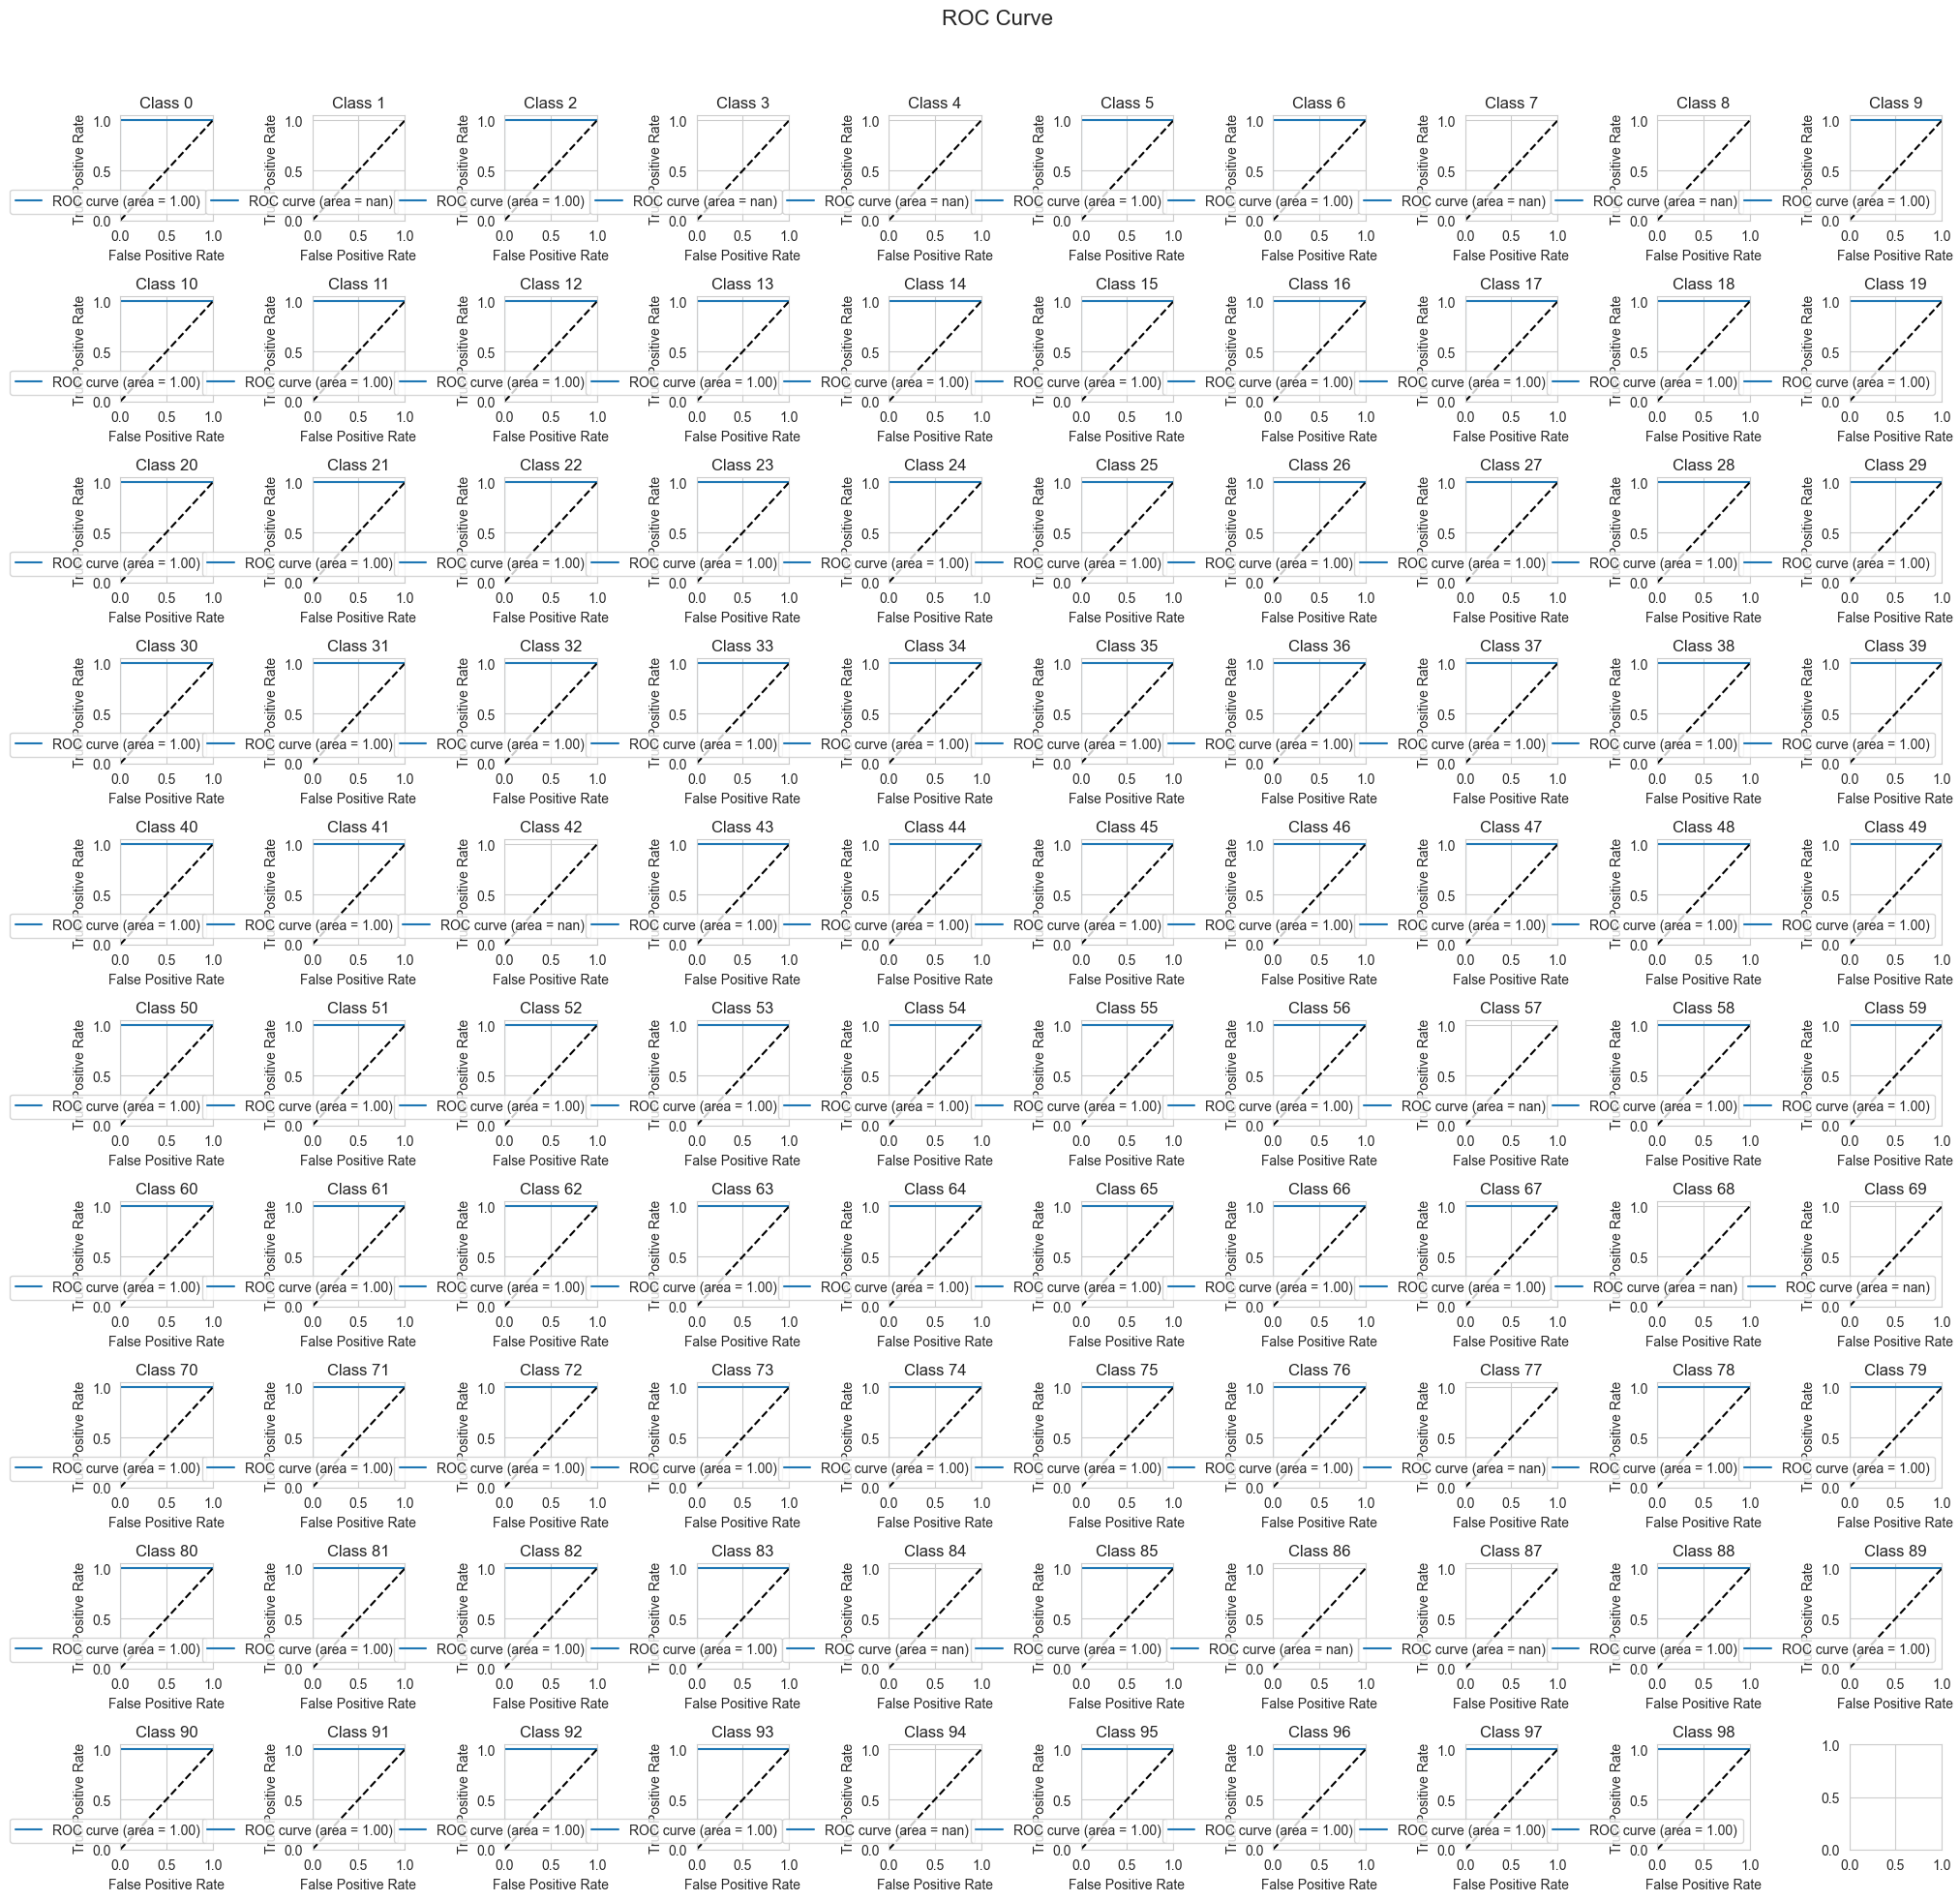

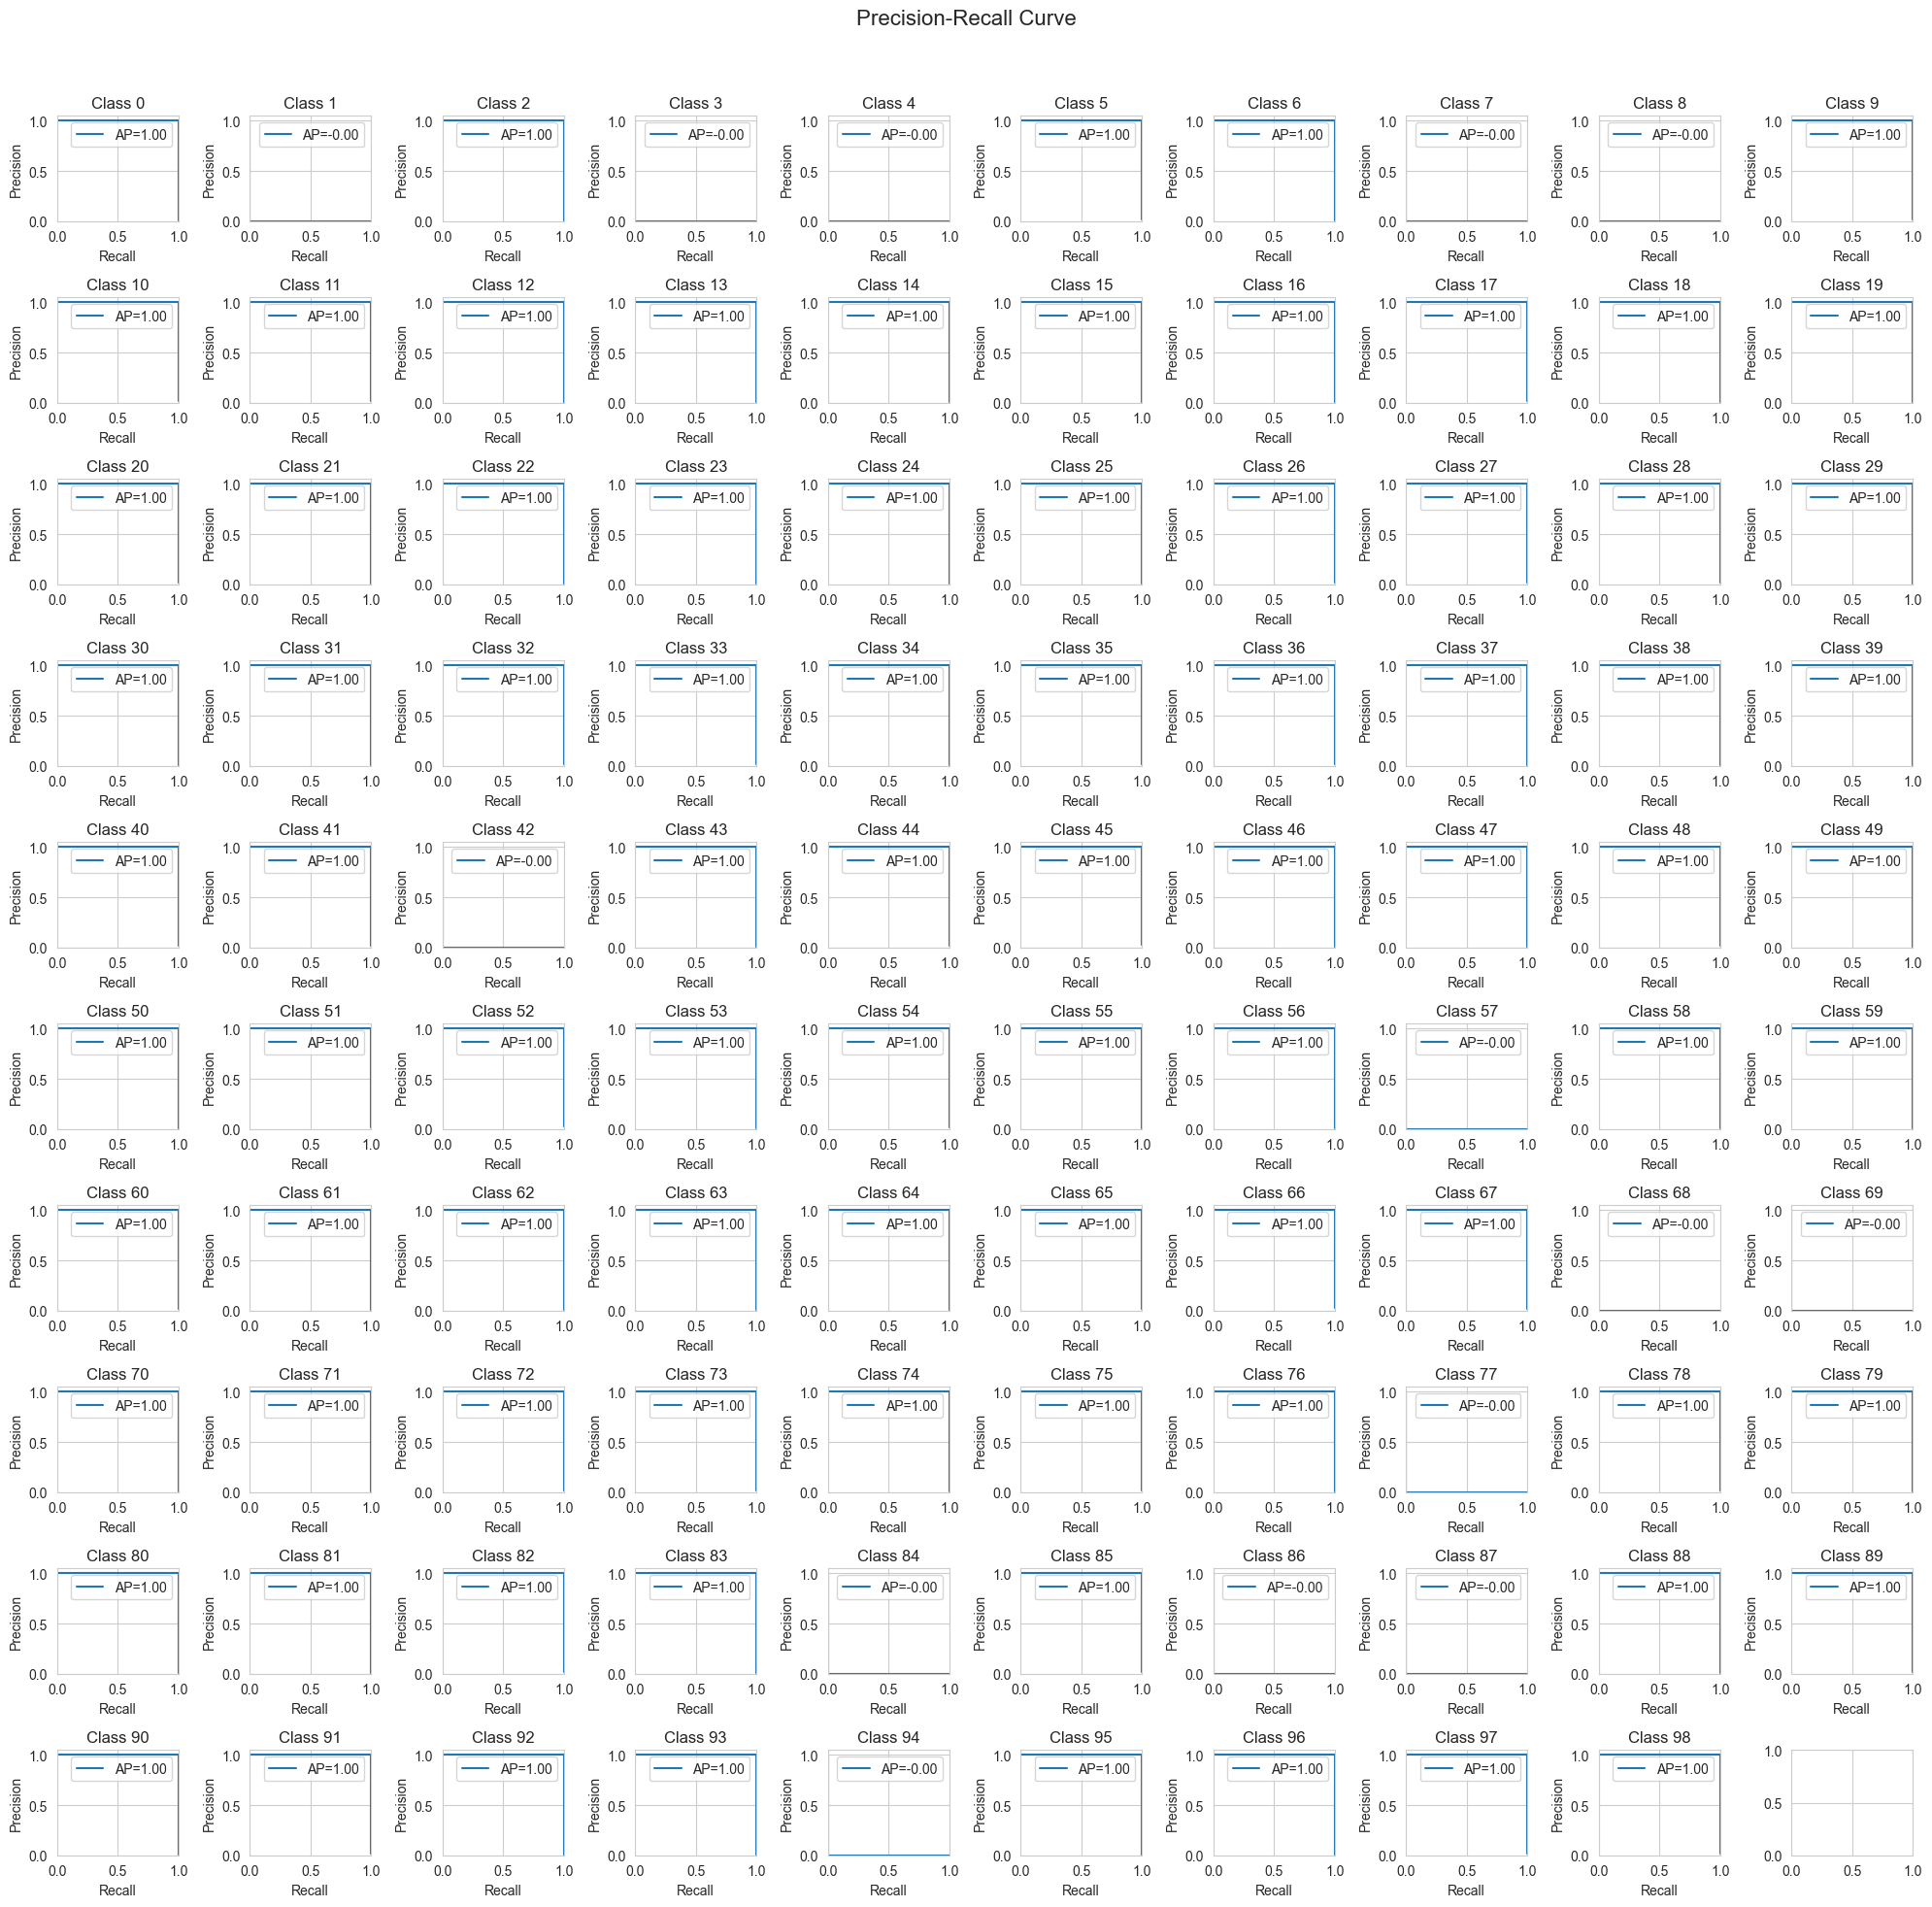

In [27]:
from sklearn.preprocessing import label_binarize

# Binarize the output. Replace 'y' with your validation labels e.g., 'y_val'
y_bin = label_binarize(y_val, classes=list(range(99)))

# Get the predicted probabilities from the best model
y_score = best_model.predict(X_val_reshaped)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Determine grid size for the plots
grid_size = int(np.ceil(np.sqrt(num_classes)))

# Set up figure for ROC plot
fig, axs = plt.subplots(grid_size, grid_size, figsize=(2*grid_size, 2*grid_size))
fig.suptitle('ROC Curve', fontsize=16)
for i, ax in enumerate(fig.axes):
    if i < num_classes:
        ax.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
        ax.plot([0, 1], [0, 1], 'k--')
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title('Class '+str(i))
        ax.legend(loc="lower right")

plt.tight_layout(rect=[0, 0, 1, 0.96]) # rect parameter ensures the suptitle does not overlap
plt.show()

# Compute Precision-Recall curve and average precision for each class
precision = dict()
recall = dict()
average_precision = dict()
for i in range(num_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_bin[:, i], y_score[:, i])
    average_precision[i] = average_precision_score(y_bin[:, i], y_score[:, i])

# Set up figure for Precision-Recall plot
fig, axs = plt.subplots(grid_size, grid_size, figsize=(2*grid_size, 2*grid_size))
fig.suptitle('Precision-Recall Curve', fontsize=16)
for i, ax in enumerate(fig.axes):
    if i < num_classes:
        ax.step(recall[i], precision[i], where='post', label='AP={0:0.2f}'.format(average_precision[i]))
        ax.set_xlabel('Recall')
        ax.set_ylabel('Precision')
        ax.set_ylim([0.0, 1.05])
        ax.set_xlim([0.0, 1.0])
        ax.set_title('Class '+str(i))
        ax.legend(loc="best")

plt.tight_layout(rect=[0, 0, 1, 0.96]) 
plt.show()

# 6. Generating the output file

In [28]:
# Use the best_model to make predictions using the test_data for up-loading on Kaggle

# Load the test data
test_df = pd.read_csv('test.csv.zip')

# Copy the original Test DataFrame
processed_test_df = test_df.copy()

# Initialize the scaler
scaler = MinMaxScaler()

# Your code seems to suggest that the 'id' column is not a feature for model training.
# Scale numeric columns
numeric_cols = processed_test_df.columns.drop(['id'])
processed_test_df[numeric_cols] = scaler.fit_transform(processed_test_df[numeric_cols])

# Define the reshape function for cnn
def reshape_for_cnn(X, n_channels):
    # Calculate the dimension of the square
    dim = int(np.sqrt(X.shape[1] // n_channels))

    # Reshape the data to (n_samples, dim, dim, n_channels) - suitable for CNN
    X_reshaped = X.values.reshape(-1, dim, dim, n_channels)
    return X_reshaped

# Reshape data for CNN
n_channels = 3 # set the number of channels according to the shape of your data

X_test = processed_test_df.drop(columns=['id'])
X_test_reshaped = reshape_for_cnn(X_test, n_channels)

# Predict the probabilities using the best model from above
test_predictions = best_model.predict(X_test_reshaped)
test_predictions = pd.DataFrame(test_predictions, columns=classes)

# Create submission DataFrame
submission_df = pd.DataFrame({'Id': test_df['id']}).join(test_predictions)

# Save DataFrame to csv
submission_df.to_csv('kaggle_submission_1.csv', index=False)

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


In [29]:
# Save the file as html
notebook_file = 'Leaf_Classification_CNN_1.ipynb'

# Create an exporter, configure, and export the report
html_exporter = nbconvert.HTMLExporter()
html_exporter.template_name = 'classic'  
body, resources = html_exporter.from_filename(notebook_file)

# Write to a file
with open(os.path.splitext(notebook_file)[0] + '.html', 'w') as f:
    f.write(body)

# 7. Conclusion: 

In conclusion, the detailed output reveals the optimal hyperparameters for the superior model, identified through meticulous hyperparameter tuning. The model features a `Conv2D` layer with 256 filters, capturing spatial patterns, and three dense layers—two with 384 units for complex feature combinations and one with 99 units for class predictions. A dropout rate of 0.5 combats overfitting by omitting half of the neurons' outputs during training. The absence of L2 regularization suggests no additional weight penalties were necessary. With a learning rate set at approximately 0.0069, these hyperparameters are finely tuned for peak performance, achieving a commendable training accuracy of 93.87% and a validation accuracy of 92.93%, underscoring the effectiveness of precise hyperparameter adjustment.